# 目标检测和边界框

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

下面加载本节将使用的示例图像。可以看到图像左边是一只狗，右边是一只猫。 它们是这张图像里的两个主要目标

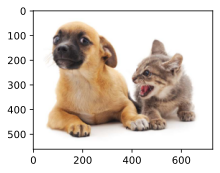

In [2]:
d2l.set_figsize()
img = d2l.plt.imread('../img/catdog.jpg')
d2l.plt.imshow(img);

## 边界框

在目标检测中，我们通常使用边界框（bounding box）来描述对象的空间位置。 边界框是矩形的，由矩形左上角的以及右下角的x和y坐标决定。 </br>
另一种常用的边界框表示方法是边界框中心的(x,y)轴坐标以及框的宽度和高度。</br>
在这里，我们定义在这两种表示法之间进行转换的函数：box_corner_to_center从两角表示法转换为中心宽度表示法，而box_center_to_corner反之亦然。 </br>
输入参数boxes可以是长度为4的张量，也可以是形状为（n，4）的二维张量，其中n是边界框的数量。

In [3]:
def box_corner_to_center(boxes):
    """从（左上，右下）转换到（中间，宽度，高度）"""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

def box_center_to_corner(boxes):
    """从（中间，宽度，高度）转换到（左上，右下）"""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

我们将根据坐标信息定义图像中狗和猫的边界框。 图像中坐标的原点是图像的左上角，向右的方向为x轴的正方向，向下的方向为y轴的正方向。

In [4]:
# bbox是边界框的英文缩写
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

我们可以通过转换两次来验证边界框转换函数的正确性。

In [5]:
boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

我们可以将边界框在图中画出，以检查其是否准确。 画之前，我们定义一个辅助函数bbox_to_rect。 它将边界框表示成matplotlib的边界框格式。

In [6]:
def bbox_to_rect(bbox, color):
    # 将边界框(左上x,左上y,右下x,右下y)格式转换成matplotlib格式：
    # ((左上x,左上y),宽,高)
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

在图像上添加边界框之后，我们可以看到两个物体的主要轮廓基本上在两个框内

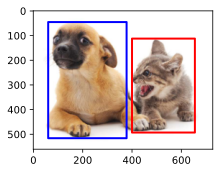

In [7]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'))

# 目标检测数据集

目标检测领域没有像MNIST和Fashion-MNIST那样的小数据集。 为了快速测试目标检测模型，我们收集并标记了一个小型数据集。 首先，我们拍摄了一组香蕉的照片，并生成了1000张不同角度和大小的香蕉图像。 然后，我们在一些背景图片的随机位置上放一张香蕉的图像。 最后，我们在图片上为这些香蕉标记了边界框。

In [8]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l


d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

### 读取数据集

通过read_data_bananas函数，我们读取香蕉检测数据集。 该数据集包括一个的CSV文件，内含目标类别标签和位于左上角和右下角的真实边界框坐标。

In [9]:
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签"""
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                             else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        # 这里的target包含（类别，左上角x，左上角y，右下角x，右下角y），
        # 其中所有图像都具有相同的香蕉类（索引为0）
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256

通过使用read_data_bananas函数读取图像和标签，以下BananasDataset类别将允许我们创建一个自定义Dataset实例来加载香蕉检测数据集。

In [10]:
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

最后，我们定义load_data_bananas函数，来为训练集和测试集返回两个数据加载器实例。对于测试集，无须按随机顺序读取它。

In [11]:
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

让我们读取一个小批量，并打印其中的图像和标签的形状。图像的小批量的形状为（批量大小、通道数、高度、宽度)，看起来很眼熟:它与我们之前图像分类任务中的相同。标签的小批量的形状为（批量大小，m，5)，其中m是数据集的任何图像中边界框可能出现的最大数量。</br>
小批量计算虽然高效，但它要求每张图像含有相同数量的边界框，以便放在同一个批量中。通常来说，图像可能拥有不同数量个边界框;因此，在达到m之前，边界框少于m的图像将被非法边界框填充。这样，每个边界框的标签将被长度为5的数组表示。数组中的第一个元素是边界框中对象的类别，其中-1表示用于填充的非法边界框。数组的其余四个元素是边界框左上角和右下角的(x,y)坐标值（值域在0~1之间)。对于香蕉数据集而言，由于每张图像上只有一个边界框，因此m=1。


In [12]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

### 演示

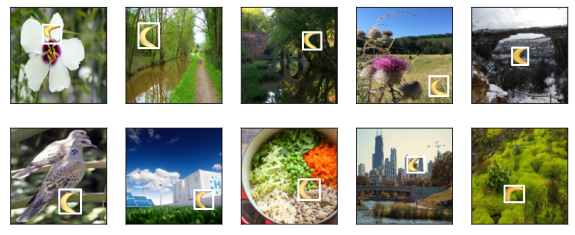

In [13]:
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

我们收集的香蕉检测数据集可用于演示目标检测模型。</br>

用于目标检测的数据加载与图像分类的数据加载类似。但是，在目标检测中，标签还包含真实边界框的信息，它不出现在图像分类中。